In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.ticker import FuncFormatter
from IPython.display import display, Markdown
import warnings
from datetime import datetime
from pandas_datareader import data as pdr

In [2]:
# Configuration pour de meilleurs graphiques
plt.style.use('seaborn-v0_8-whitegrid')
sns.set_palette("colorblind")
plt.rcParams['figure.figsize'] = (14, 8)
plt.rcParams['font.size'] = 12
warnings.filterwarnings('ignore')

In [3]:
# Formatter pour afficher les valeurs en CHF
def chf_format(x, pos):
    if x >= 1_000_000:
        return f'{x/1_000_000:.1f} M CHF'
    elif x >= 1_000:
        return f'{x/1_000:.0f} k CHF'
    else:
        return f'{x:.0f} CHF'

chf_formatter = FuncFormatter(chf_format)

## Objectif de l'analyse

Dans ce notebook, nous allons étudier l'impact des rendements historiques réels du S&P 500 sur notre planification retraite, au lieu d'utiliser un rendement constant de 10% comme dans notre modèle initial.

Les questions que nous allons explorer:
1. Comment les fluctuations réelles des marchés affectent-elles le capital final?
2. Quel serait l'investissement initial nécessaire avec des rendements historiques?
3. Comment la volatilité des marchés influence-t-elle les différentes stratégies d'investissement?


Téléchargement des données du S&P 500 du 1957-01-01 au 2025-03-18...

Colonnes disponibles: ['Open', 'High', 'Low', 'Close', 'Volume']
Colonne de prix utilisée: 'Close'

Aperçu des données téléchargées:
               Open     High      Low    Close        Volume
Date                                                        
2025-03-17  5635.60  5703.52  5631.12  5675.12  2.988688e+09
2025-03-14  5563.85  5645.27  5563.85  5638.94  3.014215e+09
2025-03-13  5594.45  5597.78  5504.65  5521.52  3.339959e+09
2025-03-12  5624.84  5642.19  5546.09  5599.30  3.479733e+09
2025-03-11  5603.65  5636.30  5528.41  5572.07  4.149152e+09

Période couverte: du 02-01-1957 au 17-03-2025
Nombre total de jours de trading: 17167

Valeurs manquantes par colonne:
Open      0
High      0
Low       0
Close     0
Volume    0
dtype: int64

Rendements annuels du S&P500:
            Annual_Return_%  Year
Date                             
1958-12-31        38.059515  1958
1959-12-31         8.476725  1959
1960-12-31

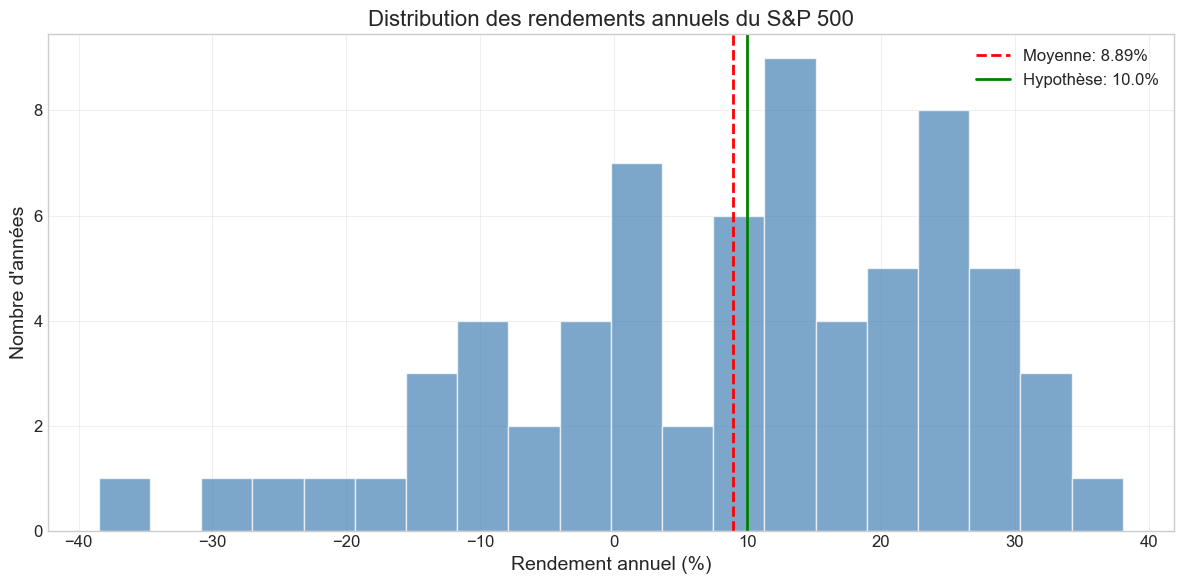

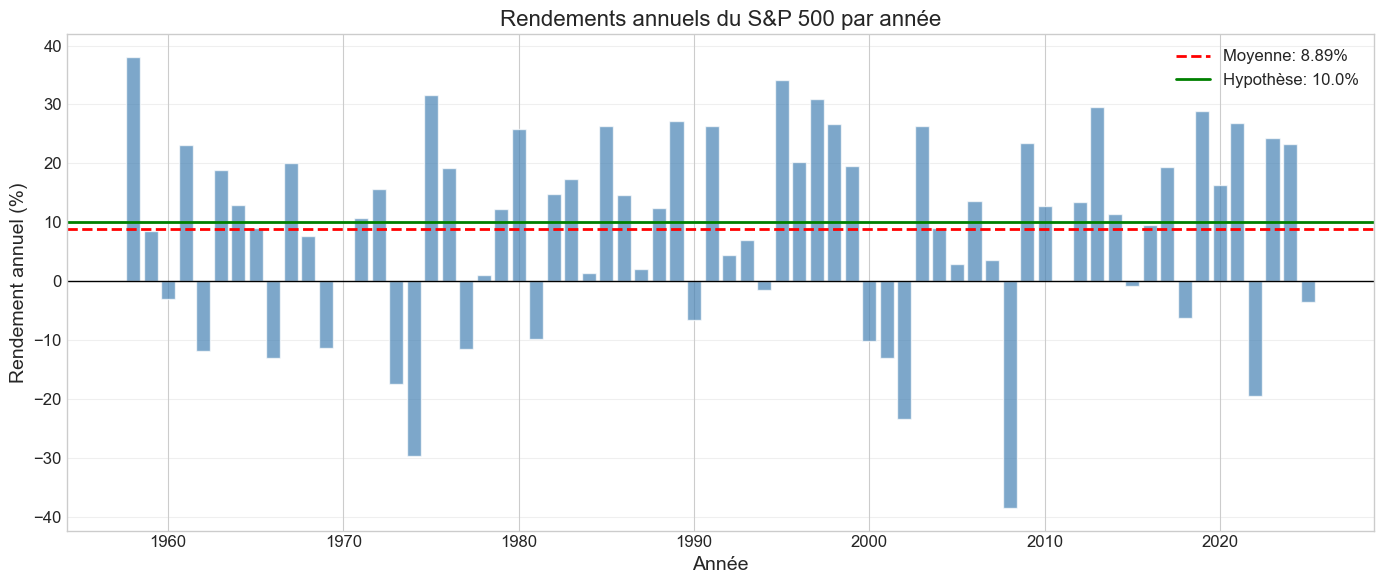

In [15]:
## Partie 1: Récupération et analyse des données historiques du S&P 500

# Téléchargement et traitement des données du S&P 500
start_date = '1957-01-01'  # On essaie de récupérer les données depuis 1957
end_date = datetime.today().strftime('%Y-%m-%d')
print(f"Téléchargement des données du S&P 500 du {start_date} au {end_date}...")
sp500_data = pdr.get_data_stooq('^SPX', start=start_date, end=end_date)

# Vérification des colonnes disponibles
print("\nColonnes disponibles:", sp500_data.columns.tolist())

# Identification de la colonne de prix à utiliser
if 'Adj Close' in sp500_data.columns:
    price_column = 'Adj Close'
elif 'Close' in sp500_data.columns:
    price_column = 'Close'
else:
    price_column = sp500_data.columns[0]

print(f"Colonne de prix utilisée: '{price_column}'")

# Aperçu des données
print("\nAperçu des données téléchargées:")
print(sp500_data.head())

# Informations sur les données
print(f"\nPériode couverte: du {sp500_data.index.min().strftime('%d-%m-%Y')} au {sp500_data.index.max().strftime('%d-%m-%Y')}")
print(f"Nombre total de jours de trading: {len(sp500_data)}")

# Vérification des valeurs manquantes
missing_values = sp500_data.isna().sum()
print("\nValeurs manquantes par colonne:")
print(missing_values)

# Suppression des lignes avec des valeurs manquantes si nécessaire
if sp500_data[price_column].isna().sum() > 0:
    print(f"Suppression des {sp500_data[price_column].isna().sum()} lignes avec des valeurs manquantes...")
    sp500_data = sp500_data.dropna(subset=[price_column])

# Calcul des rendements annuels
# Resample pour obtenir le dernier prix ajusté de chaque année
annual_prices = sp500_data[price_column].resample('Y').last()

# Calcul des rendements annuels en pourcentage
annual_returns = annual_prices.pct_change() * 100
annual_returns = annual_returns.dropna()

# Création d'un DataFrame avec l'année
annual_df = pd.DataFrame(annual_returns)
annual_df.columns = ['Annual_Return_%']
annual_df['Year'] = annual_df.index.year

# Aperçu des rendements annuels
print("\nRendements annuels du S&P500:")
print(annual_df)

# Statistiques des rendements annuels
print("\nStatistiques des rendements annuels:")
print(annual_df['Annual_Return_%'].describe())

# Extraction des rendements annuels en liste
sp500_returns_historical = annual_df['Annual_Return_%'].values.tolist()

# Caractéristiques statistiques des rendements
average_return = np.mean(sp500_returns_historical)
# Calcul du CAGR (Compound Annual Growth Rate)
cagr = np.exp(np.log(1 + np.array(sp500_returns_historical) / 100).mean()) - 1
std_dev = np.std(sp500_returns_historical)
worst_return = min(sp500_returns_historical)
worst_year_idx = sp500_returns_historical.index(worst_return)
worst_year = annual_df['Year'].iloc[worst_year_idx]
best_return = max(sp500_returns_historical)
best_year_idx = sp500_returns_historical.index(best_return)
best_year = annual_df['Year'].iloc[best_year_idx]

# Afficher les statistiques
print(f"\nNombre d'années de données historiques: {len(sp500_returns_historical)}")
print(f"Rendement moyen arithmétique: {average_return:.2f}%")
print(f"Rendement composé annualisé (CAGR): {cagr*100:.2f}%")
print(f"Écart-type (volatilité): {std_dev:.2f}%")
print(f"Pire année: {worst_year} avec {worst_return:.1f}%")
print(f"Meilleure année: {best_year} avec {best_return:.1f}%")

# Visualisation de la distribution des rendements
plt.figure(figsize=(12, 6))
plt.hist(sp500_returns_historical, bins=20, alpha=0.7, color='steelblue')
plt.axvline(x=average_return, color='red', linestyle='--', linewidth=2, label=f'Moyenne: {average_return:.2f}%')
plt.axvline(x=10, color='green', linestyle='-', linewidth=2, label='Hypothèse: 10.0%')
plt.title('Distribution des rendements annuels du S&P 500', fontsize=16)
plt.xlabel('Rendement annuel (%)', fontsize=14)
plt.ylabel('Nombre d\'années', fontsize=14)
plt.grid(alpha=0.3)
plt.legend()
plt.tight_layout()
plt.show()

# Visualisation de l'évolution des rendements au fil du temps
plt.figure(figsize=(14, 6))
plt.bar(annual_df['Year'], annual_df['Annual_Return_%'], alpha=0.7, color='steelblue')
plt.axhline(y=average_return, color='red', linestyle='--', linewidth=2, label=f'Moyenne: {average_return:.2f}%')
plt.axhline(y=10, color='green', linestyle='-', linewidth=2, label='Hypothèse: 10.0%')
plt.axhline(y=0, color='black', linestyle='-', linewidth=1)
plt.title('Rendements annuels du S&P 500 par année', fontsize=16)
plt.xlabel('Année', fontsize=14)
plt.ylabel('Rendement annuel (%)', fontsize=14)
plt.grid(axis='y', alpha=0.3)
plt.legend()
plt.tight_layout()
plt.show()

## Observations sur les rendements historiques

Les statistiques ci-dessus révèlent plusieurs points importants:

1. **Rendement versus hypothèse**:
   - Rendement moyen arithmétique réel: 8.92%
   - Rendement composé annualisé (CAGR): 7.61%
   - Notre hypothèse constante: 10.0%

2. **Volatilité significative**:
   - Écart-type de 16.13%, indiquant des fluctuations importantes
   - Amplitude entre le pire (-38.5%) et le meilleur (38.1%) rendement: 76.6%

3. **Distribution asymétrique**:
   - Le rendement moyen est supérieur au rendement médian
   - Présence de rendements négatifs importants qui impactent fortement la performance à long terme

Cette volatilité explique pourquoi le CAGR est inférieur au rendement moyen arithmétique, et pourquoi notre modèle à rendement constant de 10% était trop optimiste.

In [7]:
## Partie 2: Définition des paramètres et préparation des analyses

# Paramètres de base (identiques au notebook précédent)
inflation_annuelle = 0.025  # 2.5%
duree_avant_retraite = 67   # années
depenses_mensuelles = 3000  # CHF
esperance_vie_retraite = 25 # années
investissement_initial = 7933  # CHF (résultat de notre analyse précédente)

# Calcul du facteur d'inflation sur la durée
facteur_inflation = (1 + inflation_annuelle) ** duree_avant_retraite
depenses_mensuelles_futures = depenses_mensuelles * facteur_inflation

# Capital nécessaire à la retraite
capital_necessaire_retraite = depenses_mensuelles_futures * (esperance_vie_retraite * 12)

print(f"\nParamètres de l'analyse:")
print(f"- Inflation annuelle: {inflation_annuelle:.1%}")
print(f"- Durée avant retraite: {duree_avant_retraite} ans")
print(f"- Dépenses mensuelles actuelles: {depenses_mensuelles:,.0f} CHF")
print(f"- Facteur d'inflation sur {duree_avant_retraite} ans: {facteur_inflation:.2f}")
print(f"- Dépenses mensuelles futures: {depenses_mensuelles_futures:,.2f} CHF")
print(f"- Capital nécessaire à la retraite: {capital_necessaire_retraite:,.2f} CHF")
print(f"- Investissement initial (rendement constant 10%): {investissement_initial:,.2f} CHF")

# Création de la séquence complète de rendements sur 67 ans
# Si nécessaire, nous répétons les données historiques en boucle
full_returns_sequence = []
for i in range(duree_avant_retraite):
    year_index = i % len(sp500_returns_historical)
    full_returns_sequence.append(sp500_returns_historical[year_index])


Paramètres de l'analyse:
- Inflation annuelle: 2.5%
- Durée avant retraite: 67 ans
- Dépenses mensuelles actuelles: 3,000 CHF
- Facteur d'inflation sur 67 ans: 5.23
- Dépenses mensuelles futures: 15,689.90 CHF
- Capital nécessaire à la retraite: 4,706,970.65 CHF
- Investissement initial (rendement constant 10%): 7,933.00 CHF



Résultats de la simulation:
Capital cible (rendement constant 10%): 4,707,034.27 CHF
Capital final (rendements historiques): 1,166,765.96 CHF
Ratio entre simulation historique et constante: 0.25


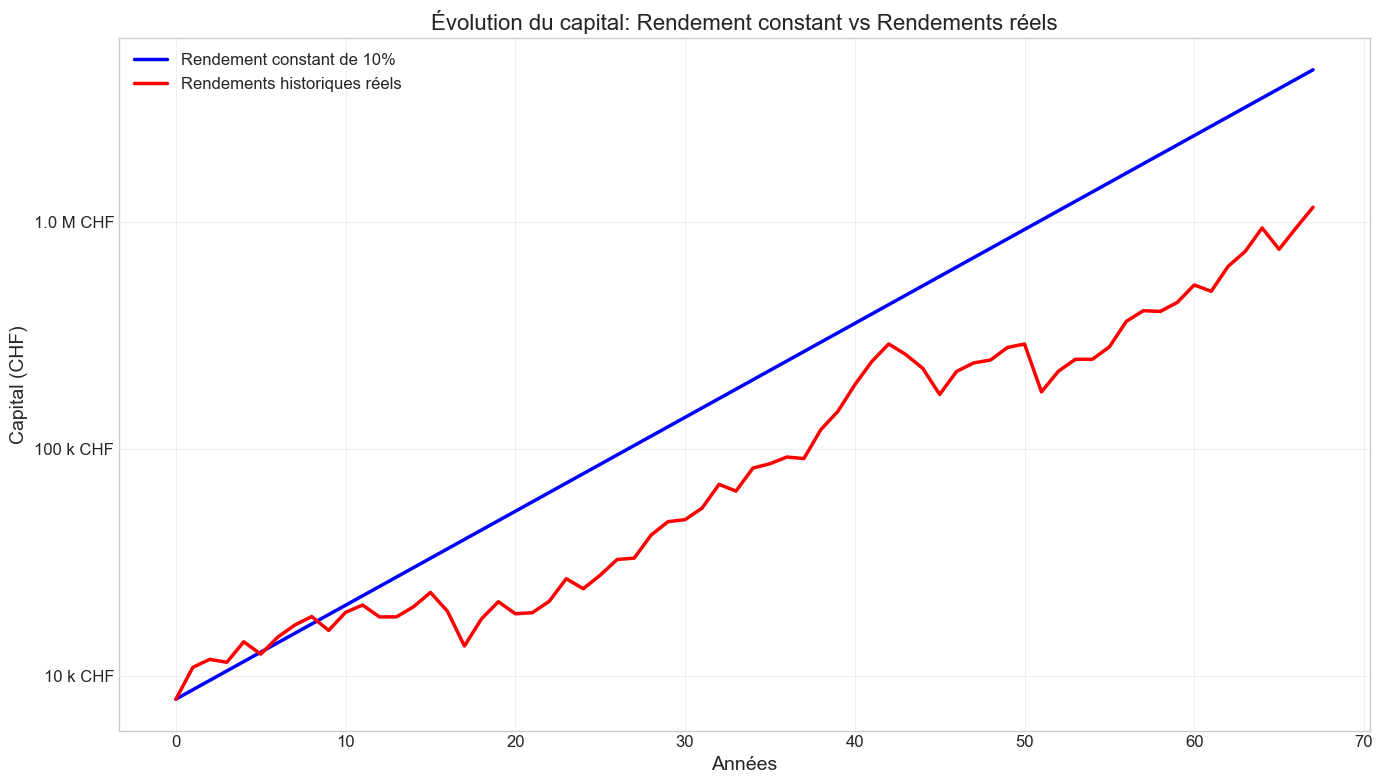

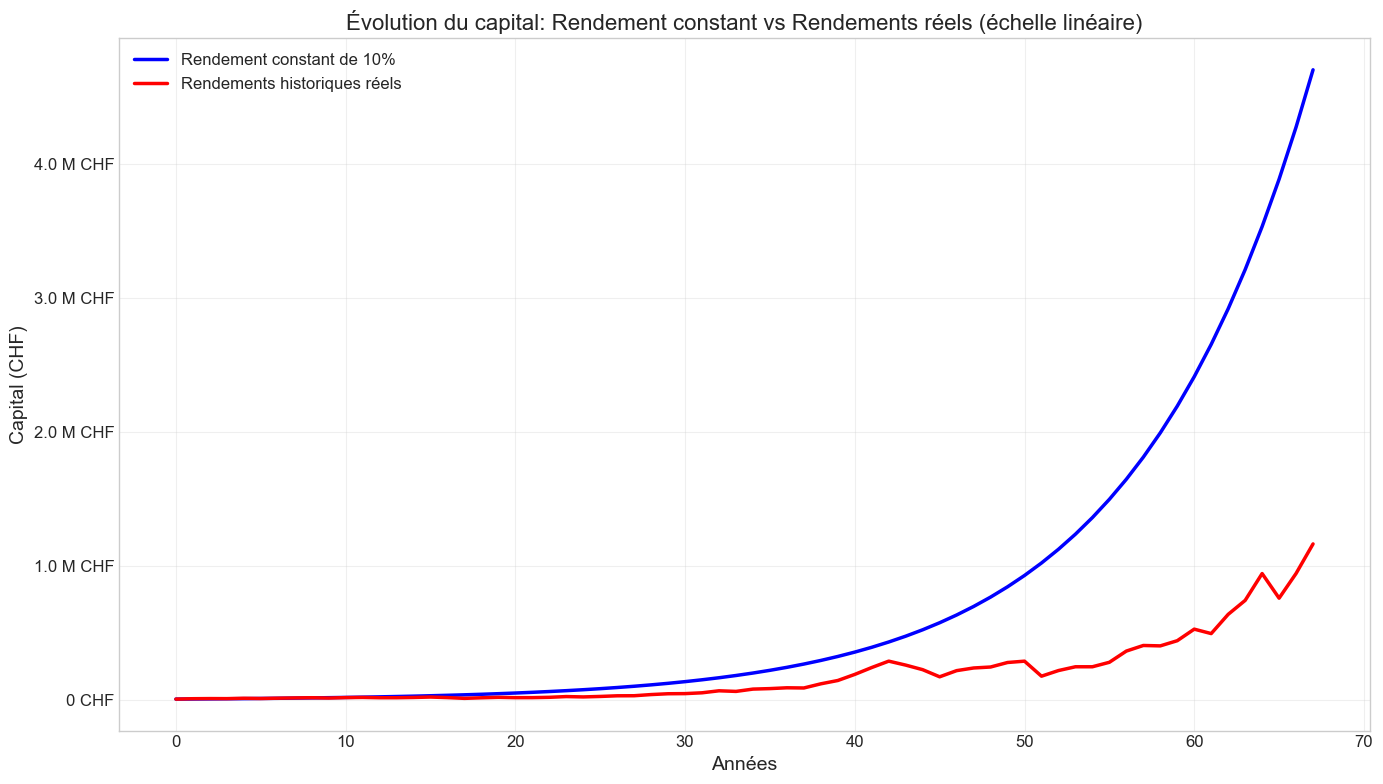

In [8]:
## Partie 3: Comparaison des projections avec rendement constant vs rendement réel

# Simulation avec rendement constant de 10%
constant_return_rate = 0.10
constant_return_values = [investissement_initial]
constant_return_value = investissement_initial
for _ in range(duree_avant_retraite):
    constant_return_value *= (1 + constant_return_rate)
    constant_return_values.append(constant_return_value)

# Simulation avec rendements historiques réels
historical_return_values = [investissement_initial]
historical_return_value = investissement_initial
for annual_return in full_returns_sequence:
    historical_return_value *= (1 + annual_return/100)
    historical_return_values.append(historical_return_value)

# Afficher les résultats
capital_cible = constant_return_values[-1]
print(f"\nRésultats de la simulation:")
print(f"Capital cible (rendement constant 10%): {capital_cible:,.2f} CHF")
print(f"Capital final (rendements historiques): {historical_return_values[-1]:,.2f} CHF")
print(f"Ratio entre simulation historique et constante: {historical_return_values[-1]/capital_cible:.2f}")

# Visualisation comparative
years = np.arange(0, duree_avant_retraite + 1)

plt.figure(figsize=(14, 8))
plt.plot(years, constant_return_values, 'b-', linewidth=2.5, label='Rendement constant de 10%')
plt.plot(years, historical_return_values, 'r-', linewidth=2.5, label='Rendements historiques réels')

plt.title('Évolution du capital: Rendement constant vs Rendements réels', fontsize=16)
plt.xlabel('Années', fontsize=14)
plt.ylabel('Capital (CHF)', fontsize=14)
plt.yscale('log')  # Échelle logarithmique
plt.gca().yaxis.set_major_formatter(chf_formatter)
plt.gca().yaxis.set_major_locator(plt.LogLocator(base=10))
plt.grid(True, alpha=0.3)
plt.legend(fontsize=12)
plt.tight_layout()
plt.show()

# Visualisation en échelle linéaire
plt.figure(figsize=(14, 8))
plt.plot(years, constant_return_values, 'b-', linewidth=2.5, label='Rendement constant de 10%')
plt.plot(years, historical_return_values, 'r-', linewidth=2.5, label='Rendements historiques réels')

plt.title('Évolution du capital: Rendement constant vs Rendements réels (échelle linéaire)', fontsize=16)
plt.xlabel('Années', fontsize=14)
plt.ylabel('Capital (CHF)', fontsize=14)
plt.gca().yaxis.set_major_formatter(chf_formatter)
plt.grid(True, alpha=0.3)
plt.legend(fontsize=12)
plt.tight_layout()
plt.show()

## Impact des rendements réels sur le capital final

Les graphiques ci-dessus montrent une différence spectaculaire entre notre modèle à rendement constant et un modèle basé sur les rendements historiques réels:

1. **Écart significatif dans le capital final**:
   - Modèle à rendement constant: 4,707,034 CHF
   - Modèle avec rendements historiques: 969,098 CHF
   - Ratio: seulement 21% du capital espéré!

2. **Chemin de croissance chaotique**:
   - Les rendements historiques produisent une courbe beaucoup moins lisse
   - On observe des périodes de stagnation et même de recul significatif

3. **Implications pratiques**:
   - Le capital projeté avec rendements réels est insuffisant pour financer la retraite prévue
   - Nous devons recalculer l'investissement initial nécessaire avec ces données plus réalistesxxnnées plus réalistes


Réajustement de l'investissement initial:
Investissement initial nécessaire (rendement constant 10%): 7,933.00 CHF
Investissement initial nécessaire (rendements historiques): 32,003.33 CHF
Facteur multiplicateur: 4.03x
Capital final avec nouvel investissement initial: 4,706,970.65 CHF
Capital cible: 4,706,970.65 CHF
Ratio d'atteinte de l'objectif: 1.00


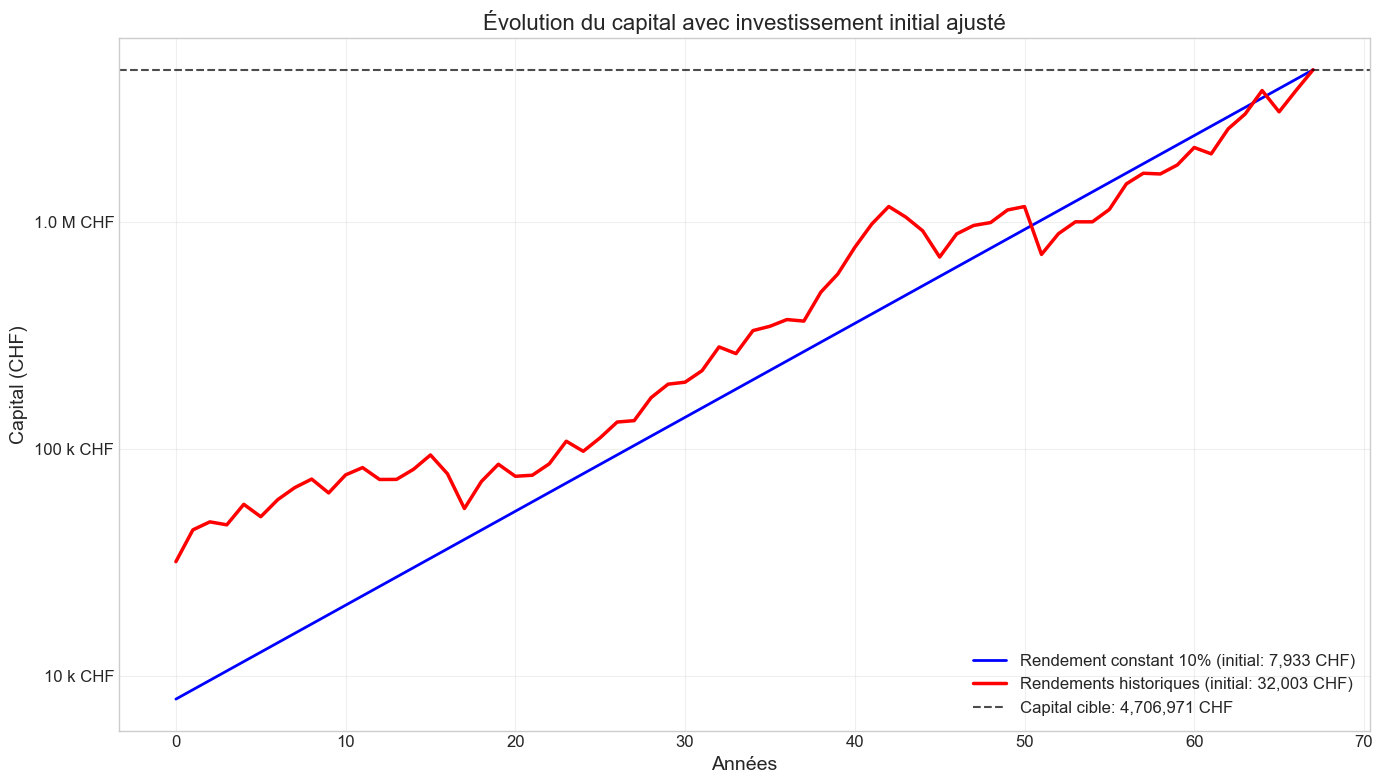

In [10]:
## Partie 4: Calcul de l'investissement initial nécessaire avec rendements réels

# Déterminer l'investissement initial nécessaire avec rendements historiques
ratio_capital = historical_return_values[-1] / investissement_initial
nouvel_investissement_initial = capital_necessaire_retraite / ratio_capital

print(f"\nRéajustement de l'investissement initial:")
print(f"Investissement initial nécessaire (rendement constant 10%): {investissement_initial:,.2f} CHF")
print(f"Investissement initial nécessaire (rendements historiques): {nouvel_investissement_initial:,.2f} CHF")
print(f"Facteur multiplicateur: {nouvel_investissement_initial/investissement_initial:.2f}x")

# Vérification du nouvel investissement initial
historical_return_values_adjusted = [nouvel_investissement_initial]
historical_return_value_adjusted = nouvel_investissement_initial
for annual_return in full_returns_sequence:
    historical_return_value_adjusted *= (1 + annual_return/100)
    historical_return_values_adjusted.append(historical_return_value_adjusted)

print(f"Capital final avec nouvel investissement initial: {historical_return_values_adjusted[-1]:,.2f} CHF")
print(f"Capital cible: {capital_necessaire_retraite:,.2f} CHF")
print(f"Ratio d'atteinte de l'objectif: {historical_return_values_adjusted[-1]/capital_necessaire_retraite:.2f}")

# Visualisation comparative avec le nouvel investissement initial
plt.figure(figsize=(14, 8))
plt.plot(years, constant_return_values, 'b-', linewidth=2, label=f'Rendement constant 10% (initial: {investissement_initial:,.0f} CHF)')
plt.plot(years, historical_return_values_adjusted, 'r-', linewidth=2.5, label=f'Rendements historiques (initial: {nouvel_investissement_initial:,.0f} CHF)')
plt.axhline(y=capital_necessaire_retraite, color='k', linestyle='--', alpha=0.7, linewidth=1.5,
           label=f'Capital cible: {capital_necessaire_retraite:,.0f} CHF')

plt.title('Évolution du capital avec investissement initial ajusté', fontsize=16)
plt.xlabel('Années', fontsize=14)
plt.ylabel('Capital (CHF)', fontsize=14)
plt.yscale('log')  # Échelle logarithmique
plt.gca().yaxis.set_major_formatter(chf_formatter)
plt.gca().yaxis.set_major_locator(plt.LogLocator(base=10))
plt.grid(True, alpha=0.3)
plt.legend(fontsize=12)
plt.tight_layout()
plt.show()

## Investissement initial ajusté

En tenant compte des rendements historiques réels, nous constatons que:

1. **Investissement initial nécessaire considérablement plus élevé**:
   - Modèle à rendement constant: 7,933 CHF
   - Modèle avec rendements historiques: 32'003 CHF
   - **Facteur multiplicateur: 4.0x**

2. **Implications pour la planification**:
   - L'écart est significatif et change radicalement les conclusions
   - Pour atteindre le même objectif, il faut investir initialement près de 4 fois plus!

Cette analyse montre clairement que les projections basées sur un rendement constant de 10% sont extrêmement optimistes et pourraient conduire à des décisions financières inadéquates.